# Individual Assignment – Pfizer (PFE) Trading Strategies


This document analyses Pfizer (PFE) using daily and weekly returns, then backtests two trading strategies:
1. A Moving Average (MA) crossover strategy.
2. A Bollinger Bands breakout strategy.

## 1. Setup – Load Packages and Global Options

We first load the core R packages needed for data manipulation, time handling, plotting, technical indicators, and performance analysis. We also turn off scientific notation to make the numerical output more readable.

In [5]:
# Big-data / core toolsy
library(data.table)      
library(dplyr)          
library(lubridate)       
library(ggplot2)         
library(TTR)            
library(PerformanceAnalytics) 

# Set global options
options(scipen = 999)   

# 2. Source Custom Backtest Functions

Here we source external R scripts that contain helper functions, e.g., for moving average crossover signals and backtest infrastructure.

In [6]:
# Source your custom functions (in separate .R script)
source("ma_backtest_functions.R") 
source("backtest_strat.R")

# 3. Load Data and Filter for Pfizer (PFE)

We load only the relevant columns from the large Compustat daily file, filter for Pfizer (ticker “PFE”), compute daily returns, and convert dates to Date objects.

In [7]:
# Load ONLY the columns we need (this keeps memory low)
dt <- fread(
  "/workspaces/apps-r-vscode-sanxuin/Individual Assignment/computstat_daily_2010_2025.csv",
  select = c("tic", "datadate", "prccd", "cshtrd", "gvkey")
)

# Filter PFE and compute returns
pfe_small <- dt %>%
  filter(tic == "PFE") %>%
  mutate(
    date = as.Date(as.character(datadate), format = "%m/%d/%Y"),
    ret  = prccd / lag(prccd) - 1
  ) %>%
  arrange(date) %>%
  as.data.table()

head(pfe_small)

Warning message in fread("/workspaces/apps-r-vscode-sanxuin/Individual Assignment/computstat_daily_2010_2025.csv", :
“Discarded single-line footer: <<DPZ,08/04/2011,DOMINO'S PIZZA INC,14,30 Frank Lloyd Wright Drive,48105,"Domino's Pizza, Inc. operates as a pizza company in the United States and internationally. The company operates through three segments: U.S. Stores, Internat>>”


tic,datadate,prccd,cshtrd,gvkey,date,ret
<chr>,<chr>,<dbl>,<dbl>,<int>,<date>,<dbl>
PFE,01/04/2010,18.93,52074710,8530,2010-01-04,NA
PFE,01/05/2010,18.66,43368460,8530,2010-01-05,-0.014263074
PFE,01/06/2010,18.60,41405070,8530,2010-01-06,-0.003215434
PFE,01/07/2010,18.53,39427720,8530,2010-01-07,-0.003763441
PFE,01/08/2010,18.68,30403370,8530,2010-01-08,0.008094981
PFE,01/11/2010,18.83,32442710,8530,2010-01-11,0.008029979


# 4. Autocorrelation of Daily Returns

We extract daily log returns (excluding NAs) and plot the autocorrelation function (ACF) to check for serial dependence in daily returns.

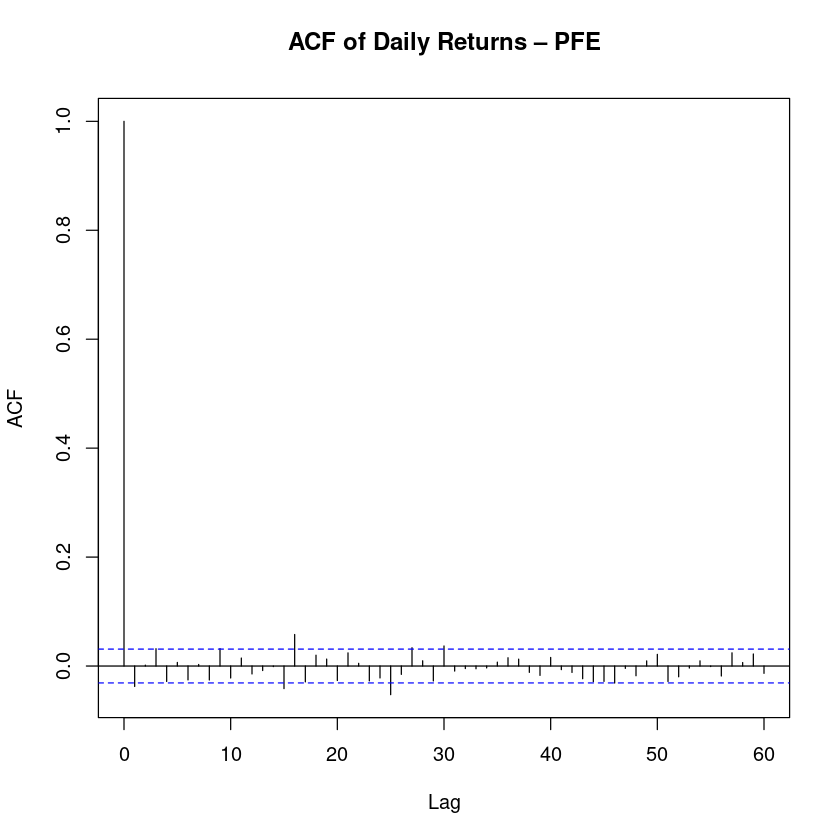

In [8]:
ret_daily <- na.omit(pfe_small$ret)

acf(
  ret_daily,
  lag.max = 60,
  main = "ACF of Daily Returns – PFE"
)

# 5. Autocorrelation of Weekly Average Returns

We aggregate daily returns into weekly average returns, then compute and plot the ACF of the weekly series. This helps us see whether autocorrelation is more pronounced at lower frequency.

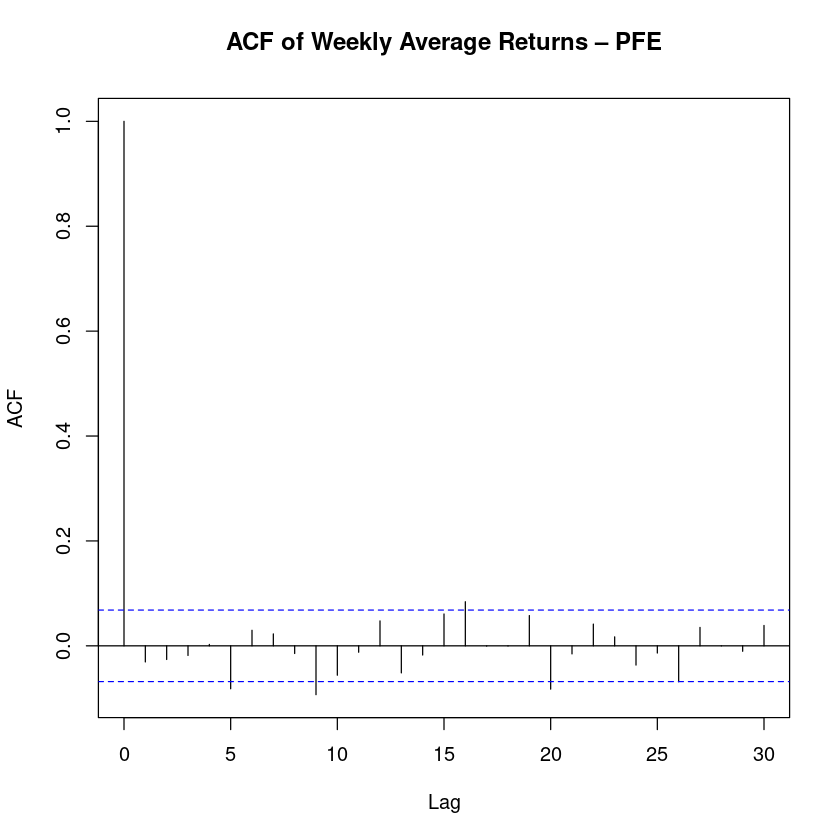

In [9]:
pfe_weekly <- pfe_small %>%
  mutate(week = floor_date(date, unit = "week")) %>%
  group_by(week) %>%
  summarise(
    ret_weekly = mean(ret, na.rm = TRUE),
    .groups = "drop"
  )

ret_weekly <- pfe_weekly$ret_weekly %>% na.omit()

acf(
  ret_weekly,
  lag.max = 30,
  main = "ACF of Weekly Average Returns – PFE"
)


# 6. Subset Data to the Post-2020 Period

For strategy backtesting, we focus on the period starting from 1 January 2020.

In [10]:
pfe_2020 <- pfe_small %>%
  filter(date >= as.Date("2020-01-01")) %>%
  arrange(date)

head(pfe_2020)

tic,datadate,prccd,cshtrd,gvkey,date,ret
<chr>,<chr>,<dbl>,<dbl>,<int>,<date>,<dbl>
PFE,01/02/2020,39.14,15667930,8530,2020-01-02,-0.001020929
PFE,01/03/2020,38.93,14158250,8530,2020-01-03,-0.005365355
PFE,01/06/2020,38.88,13547080,8530,2020-01-06,-0.001284357
PFE,01/07/2020,38.75,19083070,8530,2020-01-07,-0.003343621
PFE,01/08/2020,39.06,15563050,8530,2020-01-08,0.008000000
PFE,01/09/2020,38.89,20846030,8530,2020-01-09,-0.004352279


# 7. Prepare Prices, Returns, and Dates for Backtesting

We create vectors of prices, returns, and dates for the post-2020 sample and name the return vector by its corresponding dates. This is convenient for some backtest functions.

In [11]:
prices_2020  <- pfe_2020$prccd
rets_2020    <- pfe_2020$ret
dates_2020   <- pfe_2020$date

# Name the returns by date (useful if your backtest uses names)
names(rets_2020) <- as.character(dates_2020)

# 8. Grid Search to Optimise MA Crossover Parameters

We perform a grid search over combinations of fast and slow moving average windows. For each pair, we generate trading signals, compute strategy returns, and evaluate both total return and Sharpe ratio. The best parameter pair is chosen by Sharpe ratio.

In [12]:
fast_grid <- c(20, 30, 40, 50)
slow_grid <- c(60, 90, 120, 150)

results <- data.frame(
  fast = integer(),
  slow = integer(),
  total_return = numeric(),
  sharpe = numeric()
)

for (f in fast_grid) {
  for (s in slow_grid) {
    if (f >= s) next  # ensure fast < slow

    sig <- ma_crossover_signals(prices_2020, fast_n = f, slow_n = s)

    # Simple strategy returns (no xts yet)
    strat_ret <- rets_2020 * sig
    strat_ret[is.na(strat_ret)] <- 0

    total_ret <- prod(1 + strat_ret) - 1
    sharpe    <- mean(strat_ret) / sd(strat_ret)

    results <- rbind(
      results,
      data.frame(
        fast = f,
        slow = s,
        total_return = total_ret,
        sharpe = sharpe
      )
    )
  }
}

# Choose best by Sharpe (or total_return)
best_row <- results[which.max(results$sharpe), ]
best_row


,fast,slow,total_return,sharpe
,<dbl>,<dbl>,<dbl>,<dbl>
15,50,120,0.1787666,0.01495297


# 9. Performance of the Best MA Crossover Strategy

Using the optimal fast and slow MA windows, we rebuild the strategy signal, convert returns into an xts object, and plot a performance summary (cumulative return, drawdowns, etc.).

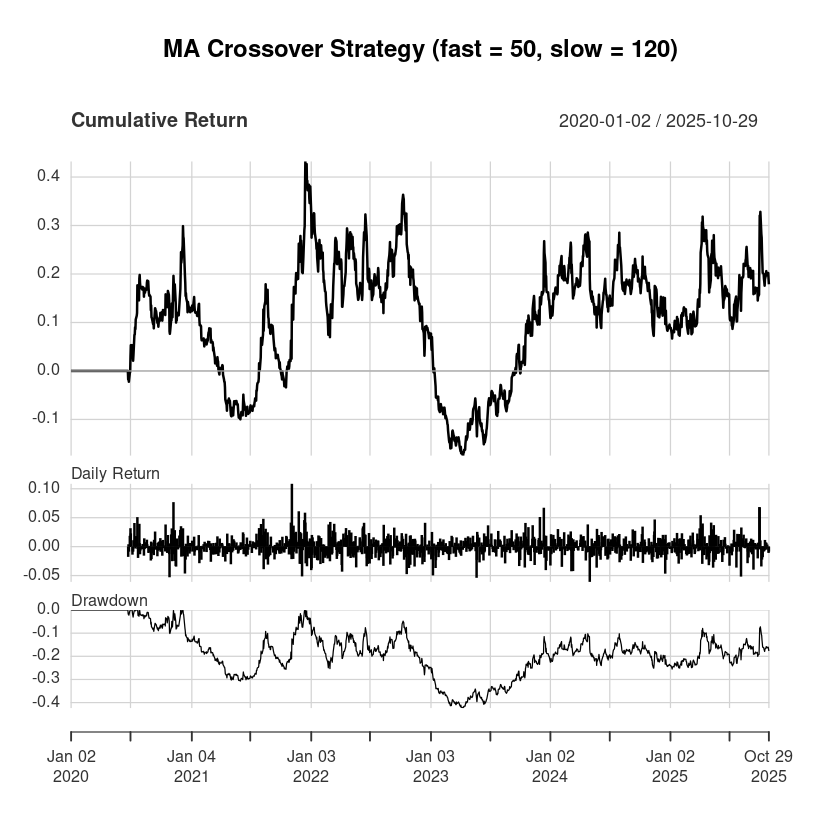

In [13]:
best_fast <- best_row$fast
best_slow <- best_row$slow

best_sig <- ma_crossover_signals(prices_2020, fast_n = best_fast, slow_n = best_slow)

library(xts)
strat_xts <- xts(rets_2020 * best_sig, order.by = dates_2020)

charts.PerformanceSummary(
  strat_xts,
  main = paste0("MA Crossover Strategy (fast = ", best_fast, ", slow = ", best_slow, ")")
)


# 10. Visualising Price with Fast and Slow Moving Averages

We overlay the price series with the fast and slow MA lines to visually inspect crossover regions and the behaviour of the strategy over time.

Warning message:
“Removed 49 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 119 rows containing missing values or values outside the scale range
(`geom_line()`).”


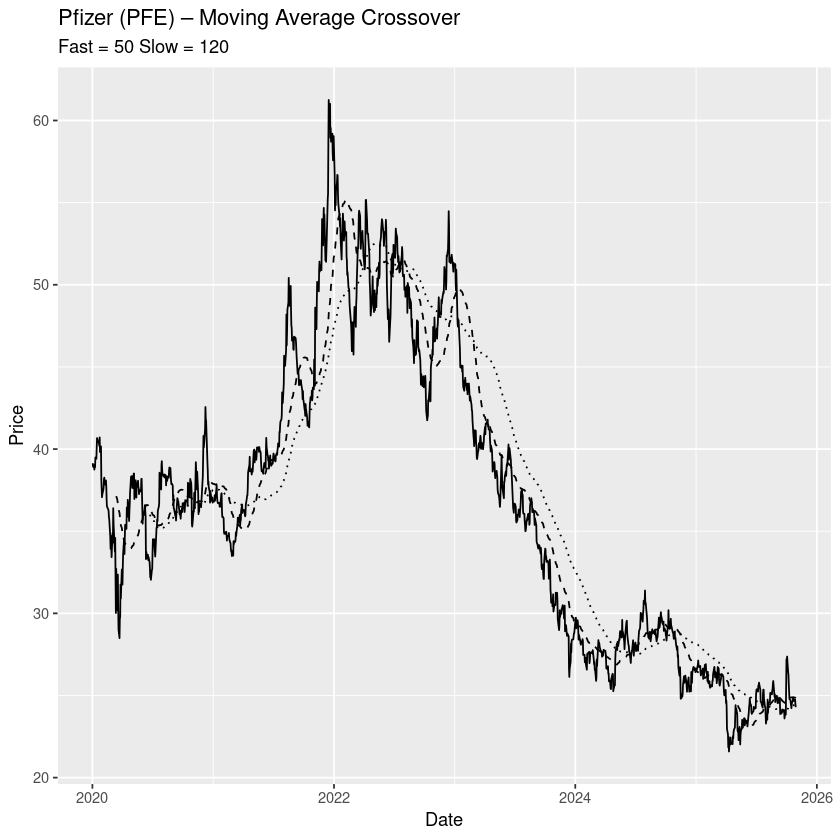

In [14]:
pfe_ma <- pfe_2020 %>%
  mutate(
    fast_ma = TTR::SMA(prccd, n = best_fast),
    slow_ma = TTR::SMA(prccd, n = best_slow),
    spread  = fast_ma - slow_ma,
    signal  = ifelse(spread > 0, 1, -1)
  )

ggplot(pfe_ma, aes(x = date)) +
  geom_line(aes(y = prccd)) +
  geom_line(aes(y = fast_ma), linetype = "dashed") +
  geom_line(aes(y = slow_ma), linetype = "dotted") + 
  labs(
    x = "Date", 
    y = "Price",
    title = "Pfizer (PFE) – Moving Average Crossover",
    subtitle = paste("Fast =", best_fast, "Slow =", best_slow)
  )


# 11. Bollinger Bands Breakout Strategy – Signal Function

We now define a Bollinger Bands breakout strategy. The idea is:

Go long (1) when price closes above the upper band.

Go short/flat (-1) when price closes below the lower band.

Otherwise, carry forward the previous position.
The resulting signal is lagged by one period to avoid look-ahead bias.

In [15]:
# Function generated with a Generative AI tool (ChatGPT) on 19 Nov 2025
# Prompt: "Generate an R function that computes signals for a Bollinger Bands Breakout Strategy.
# The function should take a price vector and return a signal vector with the same
# format as my moving average crossover signal (1 = long, -1 = short/flat, 0 = no position)."

bollinger_signals <- function(price, n = 20, k = 2) {
  # price: numeric vector of prices
  # n: lookback window for moving average and standard deviation
  # k: number of standard deviations for the bands

  ma <- TTR::SMA(price, n = n)
  sd <- TTR::runSD(price, n = n)

  upper <- ma + k * sd
  lower <- ma - k * sd

  # Basic breakout rules:
  #  - Go long when price closes above the upper band
  #  - Go short/flat when price closes below the lower band
  #  - Otherwise keep previous position
  signal_raw <- rep(0, length(price))

  for (i in seq_along(price)) {
    if (is.na(upper[i]) || is.na(lower[i])) {
      # Not enough data yet to form bands
      signal_raw[i] <- ifelse(i == 1, 0, signal_raw[i - 1])
    } else if (price[i] > upper[i]) {
      signal_raw[i] <- 1
    } else if (price[i] < lower[i]) {
      signal_raw[i] <- -1
    } else {
      # carry forward previous position
      signal_raw[i] <- ifelse(i == 1, 0, signal_raw[i - 1])
    }
  }

  # Lag to avoid look-ahead bias
  signal <- dplyr::lag(signal_raw, 1)
  signal[is.na(signal)] <- 0

  return(signal)
}


# 12. Backtest of Bollinger Bands Breakout Strategy

We apply the Bollinger Bands signal function to the post-2020 price data, compute strategy returns, and then use charts.PerformanceSummary to visualise performance.

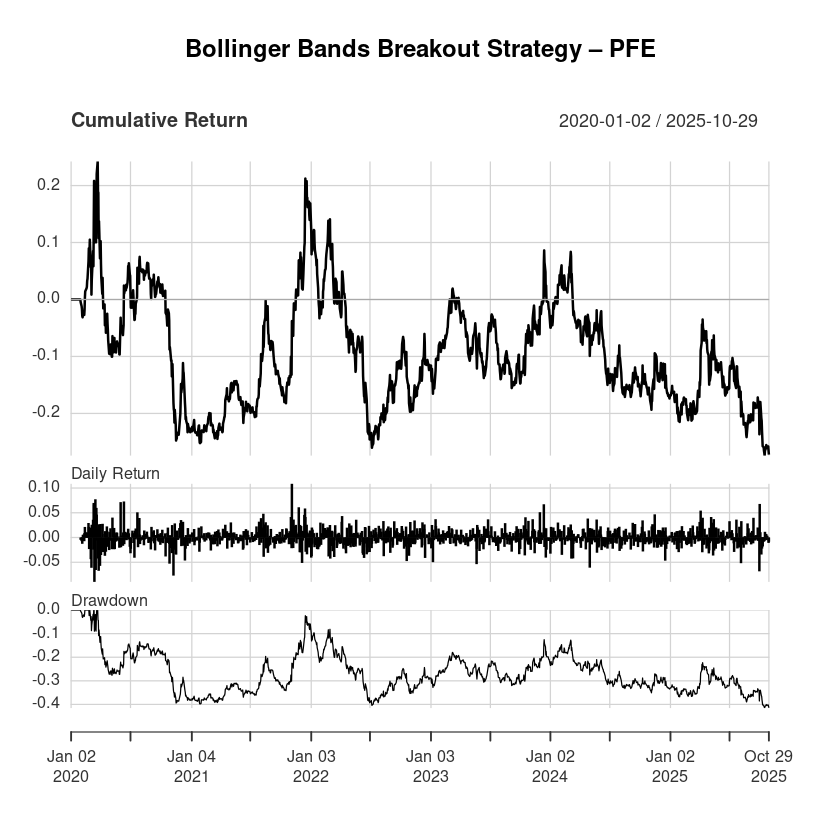

In [16]:
bb_sig <- bollinger_signals(prices_2020, n = 20, k = 2)

bb_xts <- xts(rets_2020 * bb_sig, order.by = dates_2020)

charts.PerformanceSummary(
  bb_xts,
  main = "Bollinger Bands Breakout Strategy – PFE"
)
